In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/kaggle.json ~/
! mkdir ~/.kaggle
! mv ~/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
! kaggle datasets download -d eldarsultanow/polytopes-5d-normalized-reflexive

Dataset URL: https://www.kaggle.com/datasets/eldarsultanow/polytopes-5d-normalized-reflexive
License(s): unknown
  0% 0.00/7.29M [00:00<?, ?B/s]
100% 7.29M/7.29M [00:00<00:00, 97.3MB/s]


In [5]:
! unzip polytopes-5d-normalized-reflexive.zip

Archive:  polytopes-5d-normalized-reflexive.zip
  inflating: polytopes_5d_reflexive.txt  


In [11]:
import sys
import pandas as pd
import numpy as np
import re
from ast import literal_eval
np.set_printoptions(threshold=sys.maxsize)

In [55]:
file_content = ''
with open('polytopes_5d_reflexive.txt', 'r') as file:
    file_content = file.read()

i = 0
lst_polys = []

for line in re.findall(r"^\[.*?\]$", file_content, flags=re.S | re.M):
  try:
    arr, *rest = literal_eval(line.replace("array", ""))
    lst_polys.append([str(arr)] + rest)
    i += 1
  except:
    print("omitting: {0}".format(line))
print("{0} polytopes collected".format(i))

omitting: [['0' '1' '1' '0' '2']
224272 polytopes collected


In [56]:
df = pd.DataFrame(lst_polys, columns=['matrix', 'vol', 'h11', 'h12', 'h13', 'h22', 'chi', 'numptsM', 'numvertsM', 'numptsN', 'numvertsN'])

In [64]:
df.head()

,matrix,vol,h11,h12,h13,h22,chi,numptsM,numvertsM,numptsN,numvertsN
0,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",24,4,0,232,988,1464,10,8,246,12
1,"[[1, 0, 0, 0, 0], [-1, 0, 0, 0, 0], [0, 1, 0, ...",28,4,0,244,1036,1536,10,8,260,13
2,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",36,4,0,171,744,1098,10,9,181,9
3,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",30,4,0,352,1468,2184,10,8,385,14
4,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",28,4,0,222,948,1404,10,8,238,13


In [65]:
df_sub = df.loc[:, df.columns != 'matrix']

In [66]:
df_sub.head()

,vol,h11,h12,h13,h22,chi,numptsM,numvertsM,numptsN,numvertsN
0,24,4,0,232,988,1464,10,8,246,12
1,28,4,0,244,1036,1536,10,8,260,13
2,36,4,0,171,744,1098,10,9,181,9
3,30,4,0,352,1468,2184,10,8,385,14
4,28,4,0,222,948,1404,10,8,238,13


from matplotlib import pyplot as plt
_df_21['vol'].plot(kind='hist', bins=20, title='vol')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['h13'].plot(kind='hist', bins=20, title='h13')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['h22'].plot(kind='hist', bins=20, title='h22')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['chi'].plot(kind='hist', bins=20, title='chi')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='vol', y='h13', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26.plot(kind='scatter', x='h13', y='h22', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27.plot(kind='scatter', x='h22', y='chi', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28.plot(kind='scatter', x='chi', y='numvertsM', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['h11']
  ys = series['vol']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('h11', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('h11')
_ = plt.ylabel('vol')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['h11']
  ys = series['h13']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_30.sort_values('h11', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('h11')
_ = plt.ylabel('h13')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['h11']
  ys = series['h22']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('h11', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('h11')
_ = plt.ylabel('h22')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['h11']
  ys = series['chi']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_32.sort_values('h11', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('h11')
_ = plt.ylabel('chi')

from matplotlib import pyplot as plt
_df_33['vol'].plot(kind='line', figsize=(8, 4), title='vol')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_34['h13'].plot(kind='line', figsize=(8, 4), title='h13')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['h22'].plot(kind='line', figsize=(8, 4), title='h22')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_36['chi'].plot(kind='line', figsize=(8, 4), title='chi')
plt.gca().spines[['top', 'right']].set_visible(False)

In [57]:
df.to_csv('polytopes_5d_reflexive.csv', index=True)

<Axes: xlabel='h12', ylabel='chi'>

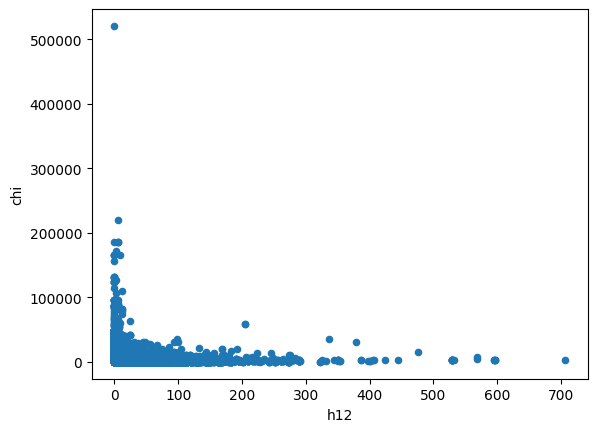

In [63]:
df.plot.scatter(x='h12', y='chi')

In [69]:
# https://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial8/tutorial8.html

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=15.5, min_samples=5).fit(df_sub)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
result = pd.concat((df_sub, labels), axis=1)
result.head()

,vol,h11,h12,h13,h22,chi,numptsM,numvertsM,numptsN,numvertsN,Cluster ID
0,24,4,0,232,988,1464,10,8,246,12,0
1,28,4,0,244,1036,1536,10,8,260,13,0
2,36,4,0,171,744,1098,10,9,181,9,0
3,30,4,0,352,1468,2184,10,8,385,14,0
4,28,4,0,222,948,1404,10,8,238,13,0


<Axes: xlabel='numptsN', ylabel='chi'>

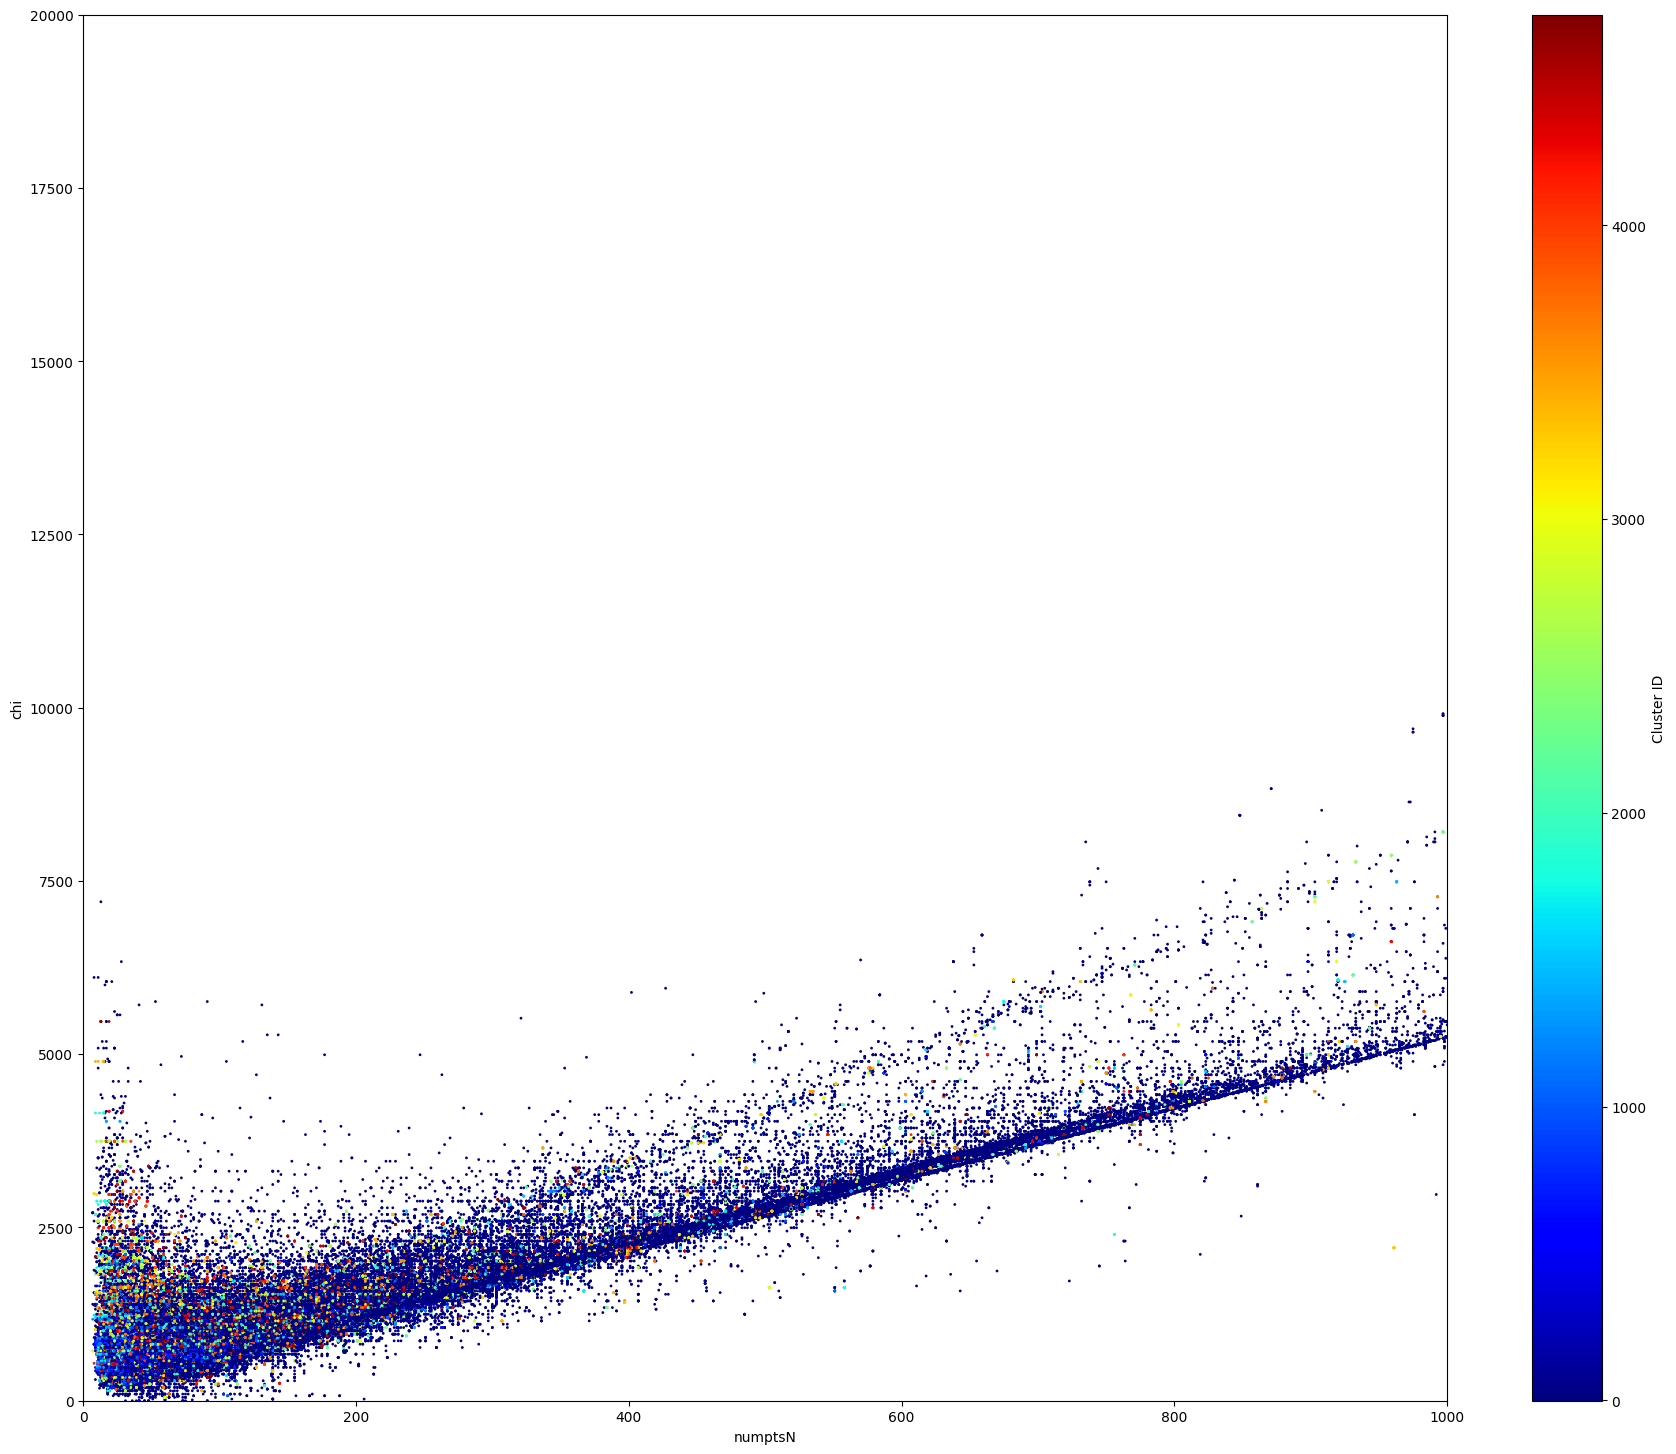

In [86]:
result.plot.scatter(figsize=(22,18), x='numptsN', y='chi', xlim=(0,1000), ylim=(0,20000), c='Cluster ID', s=1, colormap='jet')